In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import sys
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SparkSession, functions, types, Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
#assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName('example code').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [4]:
def to_null(c):
    return functions.when(~(functions.col(c).isNull() | functions.isnan(functions.col(c)) | (functions.trim(functions.col(c)) == "")), functions.col(c))


In [5]:
inputs = '15stock.csv'
minute_schema = types.StructType([
    types.StructField('DateTime', types.StringType()),
    types.StructField('windcode', types.StringType()),   
    types.StructField('close', types.DoubleType()),
    #types.StructField('volume', types.IntegerType()),
])

minutedt = spark.read.csv(inputs, schema=minute_schema)
minutedt=minutedt.select([to_null(c).alias(c) for c in minutedt.columns]).na.drop()

minutedt.createOrReplaceTempView('minutedt')
#minutedt.show(5)
notnull = spark.sql(""" SELECT DateTime, SUBSTRING_INDEX(windcode, '.',1) AS symbol,close FROM minutedt """)
notnull.createOrReplaceTempView('notnull')
#notnull.show(5)

In [6]:
pivoted = spark.sql("""SELECT * FROM 
                    ( 
                    SELECT DateTime, symbol, close
                    FROM notnull
                    ) 
                    PIVOT 
                    (
                    SUM(close)
                    FOR symbol in ("000008" AS a, "000009" AS b, '000010' AS c, '000011' AS d, '000012' AS e, "000014" AS f, "000016" AS g, '000017' AS h, '000020' AS i, '000021' AS j)                    
                    ) 
                    ORDER BY DateTime """).cache()
pivoted.createOrReplaceTempView('pivoted')

dt = spark.sql("""SELECT DateTime, a,b,c,d,e,f,g,h ,i,j FROM pivoted """).cache()
dt=dt.select([to_null(c).alias(c) for c in dt.columns]).na.drop()
dt.createOrReplaceTempView('dt')

train = spark.sql(""" SELECT * FROM dt WHERE DateTime < '2019-10-01 08:00:00' """).cache()
train.createOrReplaceTempView('train')

test = spark.sql(""" SELECT * FROM dt WHERE DateTime > '2019-10-01 08:00:00'""").cache()
test.createOrReplaceTempView('test')

In [7]:
regdt = spark.sql(""" SELECT j,i,h,g,f,e,d,c,b,a FROM train""").cache()
regdt.createOrReplaceTempView('regdt')
def find_coint(a):
    pvalue ={}
    count =0 
    for i in regdt.columns:
        count +=1
        for j in regdt.columns[count:]:
            if i != j:
    #calculate slope, intercept using 2 year(2018-2019) window between two underlyers to determine their relationship
                logdt = spark.sql(""" SELECT log({0}) AS y,log({1}) AS x FROM regdt""".format(i,j))
                logdt.createOrReplaceTempView('logdt')
                vectorAssembler = VectorAssembler(inputCols=['x'], outputCol="features")

                lr = LinearRegression(featuresCol='features', labelCol= 'y')

                stages = [vectorAssembler, lr]  

                pipeline = Pipeline(stages=stages)
                model = pipeline.fit(logdt)

                slope = model.stages[-1].coefficients[0]
                intercept = model.stages[-1].intercept

                spddt = spark.sql(""" SELECT (y - {0}* x - {1} )AS spread FROM logdt""".format(slope,intercept))
                spddt.createOrReplaceTempView('spddt')
                spddt = spddt.toPandas()
                adfSpread = adfuller(spddt['spread'] , autolag ='AIC')
                adf_pvalue = adfSpread[1]
                #print(i,j,slope,intercept,pvalue)
                pvalue[(i,j)] = (adf_pvalue, intercept, slope)
                
    min_pvalue = 0.05
    slope =0
    intercept = 0
    pair1 = 0
    pair2 = 0
    for k,v in pvalue.items():
        if v[0] < min_pvalue:
            min_pvalue = v[0]
            slope = v[2]
            intercept = v[1]
            pair1 = k[0]
            pair2 = k[1]      
    
    return (pair1,pair2, min_pvalue, slope, intercept)    

In [8]:
coint_pair = find_coint(regdt)
pair1 = coint_pair[0]
pair2 = coint_pair[1]
slope = coint_pair[3]
intercept = coint_pair[4]

In [9]:
#calculate spread of the train window 
dt1 = spark.sql(""" SELECT DateTime, j,i,h,g,f,e,d,c,b,a FROM train""")
dt1.createOrReplaceTempView('dt1')
dt2 = spark.sql(""" SELECT DateTime, {0}, {1}, (log({0}) - log({1}) * {2} - {3}) AS spread FROM dt1 """.format(pair1,pair2,slope,intercept))
dt2.createOrReplaceTempView('dt2')
mu = dt2.agg(functions.avg(dt2['spread'])).collect()[0][0]
std = dt2.agg(functions.stddev(dt2['spread'])).collect()[0][0]
#set trading signal boundries if the spread is 2 times standard deviation from spread mean
up = mu +std*1.8
down = mu - std*1.8
#set stop_loss point
upsl = mu +std*2.8
downsl = mu - std*2.8
#set take profit point
uptp = mu +std*0.2
downtp = mu - std*0.2

C:\Users\Belo\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


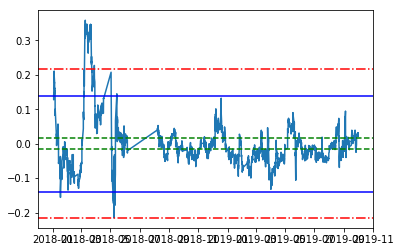

In [10]:
#plot on train window 
a = dt2.toPandas()
a['DateTime'] = pd.to_datetime(a['DateTime'], format='%Y-%m-%d %H:%M:%S')
plt.plot(a['DateTime'],a['spread'])
plt.axhline(up,color='blue',ls='-')
plt.axhline(down,color='blue',ls='-')
plt.axhline(uptp,color='green',ls='--')
plt.axhline(downtp,color='green',ls='--')
plt.axhline(upsl,color='red',ls='-.')
plt.axhline(downsl,color='red',ls='-.')
#plt.plot(a['I'])
#plt.plot(a['J'])

In [ ]:
#dt3 = spark.sql(""" SELECT DateTime, {0},{1} FROM test""".format(pair1,pair2))
#dt3.createOrReplaceTempView('dt3')


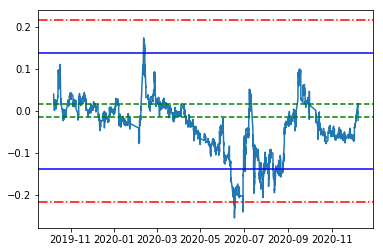

In [11]:
test1 = spark.sql(""" SELECT DateTime, {0}, {1}, (log({0}) - log({1}) * {2} - {3}) AS spread FROM test """.format(pair1,pair2,slope,intercept))
test1.createOrReplaceTempView('test1')
b = test1.toPandas()
b['DateTime'] = pd.to_datetime(b['DateTime'], format='%Y-%m-%d %H:%M:%S')
plt.plot(b['DateTime'],b['spread'])
plt.axhline(up,color='blue',ls='-')
plt.axhline(down,color='blue',ls='-')
plt.axhline(uptp,color='green',ls='--')
plt.axhline(downtp,color='green',ls='--')
plt.axhline(upsl,color='red',ls='-.')
plt.axhline(downsl,color='red',ls='-.')

In [12]:
#use up/down boundries to determine trade position in test dataset (2020)
test1 = test1.withColumn("up", functions.lit(up) )
test1 = test1.withColumn("down",functions.lit( down) )
test1 = test1.withColumn("upsl",functions.lit( upsl) )
test1 = test1.withColumn("downsl", functions.lit(downsl) )
test1 = test1.withColumn("uptp", functions.lit(uptp) )
test1 = test1.withColumn("downtp", functions.lit(downtp) )
test1 = test1.withColumn("mu",functions.lit( mu) )
test1.createOrReplaceTempView('test1')

In [13]:
#set trade positions based on signal
test1 = spark.sql(""" SELECT DateTime, {0}, {1}, spread,
            CASE 
                WHEN spread >=upsl THEN 3
                WHEN spread >=up AND spread <upsl THEN 2
                WHEN spread >=uptp AND spread <up THEN 1
                WHEN spread < downsl THEN -3
                WHEN spread < down AND spread >=downsl THEN -2
                WHEN spread < downtp AND spread >=down THEN -1
            ELSE 0
            END AS level FROM test1 """ .format(pair1,pair2))

test1.createOrReplaceTempView('test1')

In [14]:
#set trade signal
test1 = test1.withColumn('position',functions.lit(0) )
test1 = test1.withColumn('signal',functions.lit(0) )
test1 = test1.toPandas()
for i in range(1, len(test1)):
    if test1['level'][i-1] ==1 and test1['level'][i] ==2:      #open position -> short I, long J
        test1.loc[i,'signal'] = -2
    elif test1['level'][i-1] ==1 and test1['level'][i] ==0:      #take profit -I+J -> long I, short J
        test1.loc[i,'signal'] = 2 
    elif test1['level'][i-1] ==2 and test1['level'][i] ==3:      #stop loss -I+J -> long I, short J
        test1.loc[i,'signal'] = 3 
    elif test1['level'][i-1] == -1 and test1['level'][i] == -2:      #open position -> long I, short J
        test1.loc[i,'signal'] = 1 
    elif test1['level'][i-1] == -1 and test1['level'][i] ==0:      #take profit +I-J -> short I, long J
        test1.loc[i,'signal'] = -1
    elif test1['level'][i-1] ==-2 and test1['level'][i] ==-3:      #stop loss +I-J -> short I, long J
        test1.loc[i,'signal'] = -3 

In [15]:
#set trade position 
for i in range(1,len(test1)):
    test1.loc[i,'position'] = test1['position'][i-1]
    if test1['signal'][i] == 1:
        test1.loc[i,'position'] = 1
    elif test1['signal'][i] == -2:
        test1.loc[i,'position'] = -1
    elif test1['signal'][i] == -1 and test1['position'][i-1] == 1:
        test1.loc[i,'position'] = 0
    elif test1['signal'][i] == 2 and test1['position'][i-1] == -1:
        test1.loc[i,'position'] = 0
    elif test1['signal'][i] == 3:
        test1.loc[i,'position'] = 0
    elif test1['signal'][i] == -3:
        test1.loc[i,'position'] = 0

In [16]:
size=1000
test1['pair1_share'] = test1['position']*size
test1['pair2_share'] = round( - test1['pair1_share'] *slope *  test1[pair1]/ test1[pair2] )
test1['cash'] = 5000

In [17]:
test3 = test1
for i in range(1,len(test3)):
    test3.loc[i,'pair2_share'] = test3['pair2_share'][i-1]
    test3.loc[i,'cash'] = test3['cash'][i-1] 
    if test3['position'][i-1] == 0 and test3['position'][i]  ==1:
        test3.loc[i,'pair2_share'] = round( - test3['pair1_share'][i] *slope *  test3[pair1][i]/ test3[pair2][i] )
        test3.loc[i, 'cash'] =  test3['cash'][i-1] - (test3['pair1_share'][i] *  test3[pair1][i] + test3['pair2_share'][i] *  test3[pair2][i] )
    elif test3['position'][i-1] == 0 and test3['position'][i]  == -1:
        test3.loc[i,'pair2_share'] = round( - test3['pair1_share'][i] *slope *  test3[pair1][i]/ test3[pair2][i] )
        test3.loc[i, 'cash'] =  test3['cash'][i-1] - (test3['pair1_share'][i] *  test3[pair1][i] + test3['pair2_share'][i] *  test3[pair2][i] )
    elif test3['position'][i-1] == 1 and test3['position'][i]  ==0:
        test3.loc[i,'pair2_share'] = 0
        test3.loc[i,'cash'] =  test3['cash'][i-1] + (test3['pair1_share'][i-1] *  test3[pair1][i] + test3['pair2_share'][i-1] *  test3[pair2][i] )
    elif test3['position'][i-1] == -1 and test3['position'][i]  == 0:
        test3.loc[i,'pair2_share'] = 0
        test3.loc[i,'cash'] =  test3['cash'][i-1] + (test3['pair1_share'][i-1] *  test3[pair1][i] + test3['pair2_share'][i-1] *  test3[pair2][i] )

test3['asset'] = test3['cash']+ test3['pair1_share']*test3[pair1] +test3['pair2_share']*test3[pair2] 

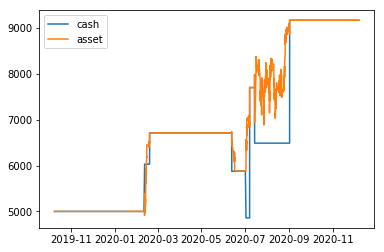

In [18]:
b = test3
b['DateTime'] = pd.to_datetime(b['DateTime'], format='%Y-%m-%d %H:%M:%S')
plt.plot(b['DateTime'],b['cash'] )
plt.plot(b['DateTime'],b['asset'] )
plt.legend()
plt.show()


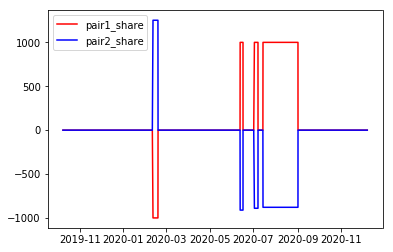

In [19]:
plt.plot(b['DateTime'],b['pair1_share'],color ='r' )
plt.plot(b['DateTime'],b['pair2_share'], color ='b' )
plt.legend()
plt.show()


In [37]:
test3.to_csv('retcsv.csv', index = True) 